<a href="https://colab.research.google.com/github/ruhend/tensorflower/blob/master/Lesson6/Cats_and_Dogs_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer Learning

## Imports

In [8]:
import tensorflow as tf

import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import layers
print(tf.__version__)
import logging

2.8.0


In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

#### Decode the predictions

In [3]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes


In [4]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [5]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [10]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'boxer', 'cougar', 'tabby', 'Tibetan mastiff',
       'Rhodesian ridgeback', 'boxer', 'boxer', 'Siamese cat',
       'soft-coated wheaten terrier', 'Egyptian cat', 'Cardigan',
       'black-and-tan coonhound', 'Persian cat', 'tabby', 'schipperke',
       'black-and-tan coonhound', 'American Staffordshire terrier',
       'American Staffordshire terrier', 'tabby', 'tabby', 'tabby',
       'Border collie', 'American Staffordshire terrier',
       'Australian terrier', 'Staffordshire bullterrier', 'Egyptian cat',
       'groenendael', 'Greater Swiss Mountain dog', 'Persian cat',
       'miniature pinscher', 'tiger cat'], dtype='<U30')

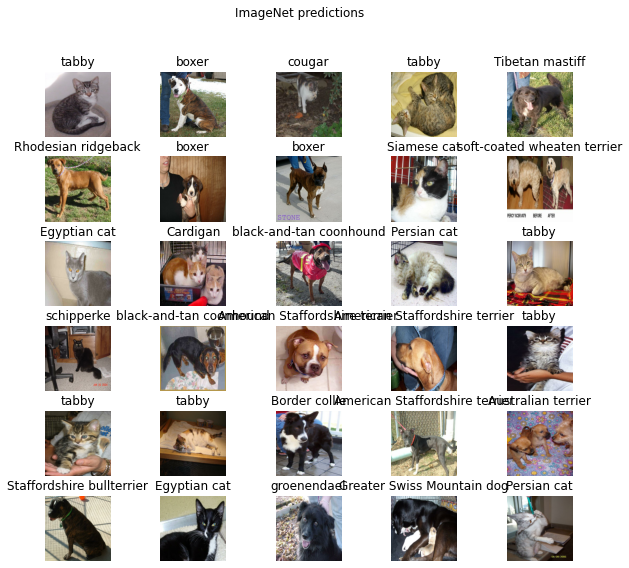

In [11]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [13]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [14]:
feature_extractor.trainable = False

In [15]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the Model

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 47s 62ms/step - loss: 0.0540 - accuracy: 0.9806 - val_loss: 0.0321 - val_accuracy: 0.9895
Epoch 2/6
582/582 [==============================] - 40s 62ms/step - loss: 0.0300 - accuracy: 0.9899 - val_loss: 0.0327 - val_accuracy: 0.9897
Epoch 3/6
582/582 [==============================] - 40s 62ms/step - loss: 0.0255 - accuracy: 0.9912 - val_loss: 0.0369 - val_accuracy: 0.9871
Epoch 4/6
582/582 [==============================] - 40s 62ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 0.0314 - val_accuracy: 0.9916
Epoch 5/6
582/582 [==============================] - 36s 55ms/step - loss: 0.0190 - accuracy: 0.9934 - val_loss: 0.0336 - val_accuracy: 0.9899
Epoch 6/6
582/582 [==============================] - 37s 56ms/step - loss: 0.0173 - accuracy: 0.9940 - val_loss: 0.0395 - val_accuracy: 0.9882


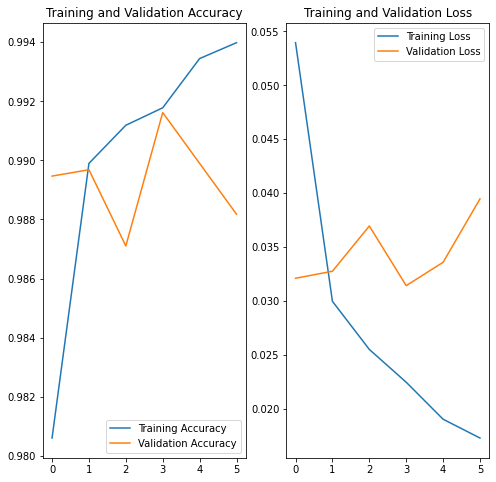

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Checking Predictions

In [18]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [19]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat',
       'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat',
       'dog', 'dog', 'cat', 'dog', 'cat'], dtype='<U3')

In [20]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0]
Predicted labels:  [0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0]


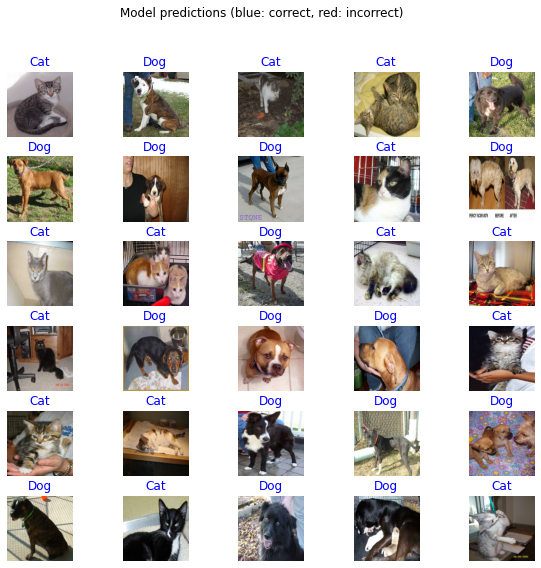

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")